# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from pygsp import graphs, reduction
from scipy import linalg
from sklearn.cluster import KMeans
from pyunlocbox import functions, solvers
import networkx as nx
from IPython.display import display, HTML
from helpers import *

## Load processed data

In [2]:
votes = pd.read_pickle("data/processed/processed_votes.pickle")
print(votes.shape)
display(votes.index)

(105, 18)


Index(['A000360', 'B000575', 'B000944', 'B001135', 'B001230', 'B001236',
       'B001261', 'B001267', 'B001277', 'B001288',
       ...
       'T000464', 'T000476', 'U000039', 'V000128', 'W000437', 'W000779',
       'W000802', 'W000805', 'W000817', 'Y000064'],
      dtype='object', name='member_id', length=105)

## Load labels

## Building the similarity graph

(105, 2)


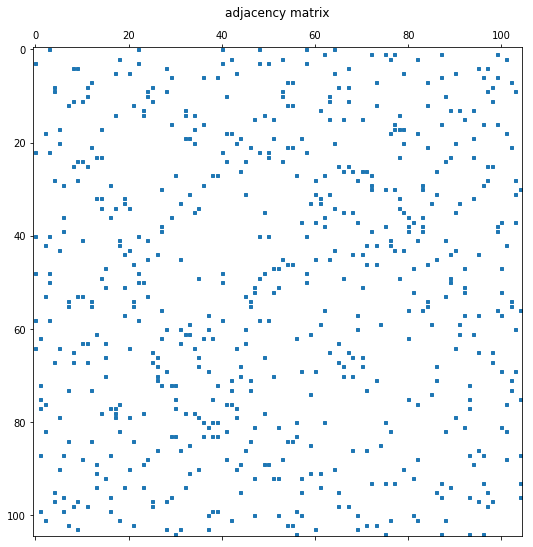

<Figure size 1440x720 with 0 Axes>

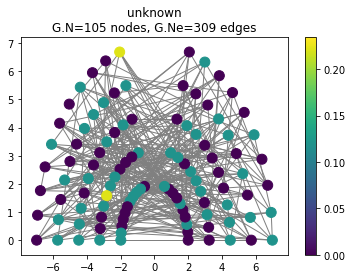

In [22]:
features = [votes.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg, 6),0.55)]

adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)
senators = pd.read_pickle("data/processed/processed_senators.pickle")
labels = np.load("data/processed/processed_labels_numerical.npy")
argsort_labels = np.argsort(labels)

"""
# Remove nodes without neighbors
node_degrees = np.count_nonzero(adjacency, axis=1)
nodes_to_keep = np.nonzero(node_degrees)[0]
adjacency = adjacency[nodes_to_keep,:][:,nodes_to_keep]

labels_kept = labels[nodes_to_keep]
"""

def build_coordinates():
    coord = []
    for a in np.linspace(0, np.pi / 2.0 - 0.3, 10):
        for r in np.linspace(2,7,5): 
            coord.append([r * np.cos(a), r * np.sin(a)])
       
    for a in np.linspace(np.pi / 2.0 + 0.3, np.pi, 11):
        for r in np.linspace(2,7,5):    
            coord.append([r * np.cos(a), r * np.sin(a)])
            
    return coord

coord = np.array(build_coordinates())
print(coord.shape)

plot_adjacency(adjacency)

plt.figure(figsize=(20,10))
G = graphs.Graph(adjacency)
G.set_coordinates(coord)
G.plot_signal(labels)

[]


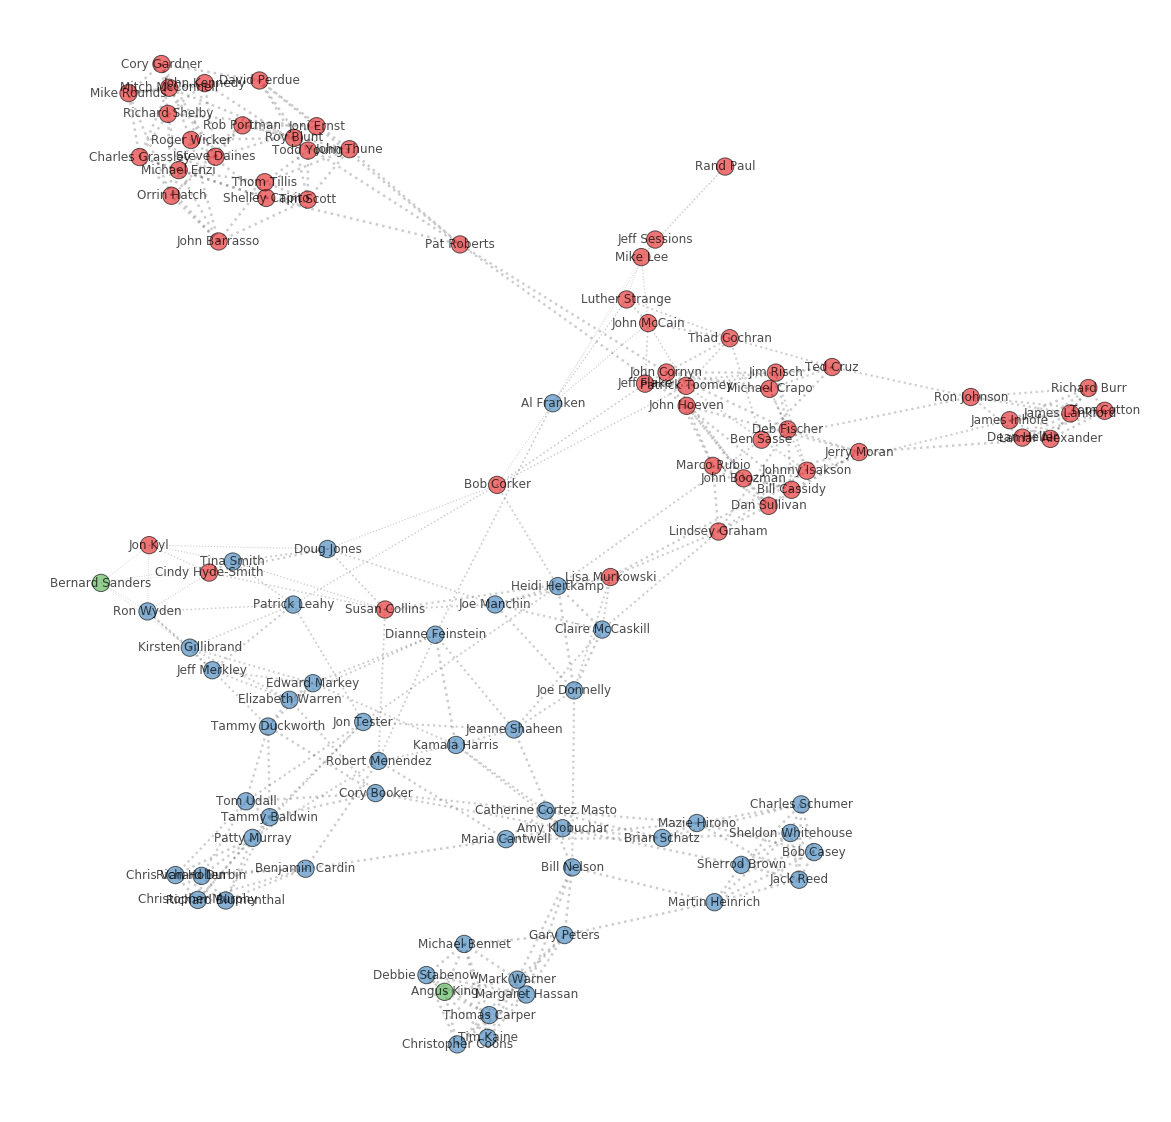

In [39]:
plt.figure(figsize=(20,20))
plot_signal(G.W.todense(), labels, labels=senators['name'], scale=[0,1])

## Embedding you in the graph

In [24]:
bill_selection = [5,10,15]
your_votes = [1,-1,1]

other_senators_vote = votes.values[:,bill_selection]

In [25]:
def compute_similarity(senator_votes):
    return euclidean_distance(senator_votes, your_votes)

similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote)
similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.7)
similarity_vector

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.76915872, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.76915872, 0.76915872, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.76915872, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

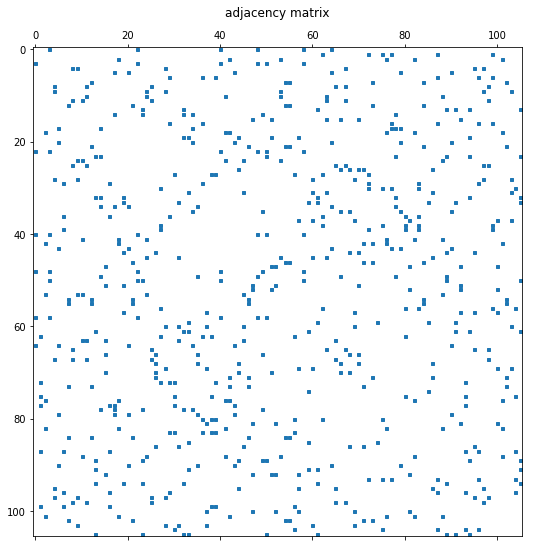

In [26]:
new_columns = np.append(similarity_vector, 0)

n = len(adjacency)
new_adjacency = np.zeros((n+1, n+1))
new_adjacency[:n,:n] = adjacency
new_adjacency[n,:] = new_columns
new_adjacency[:,n] = new_columns

plot_adjacency(new_adjacency)

['you']


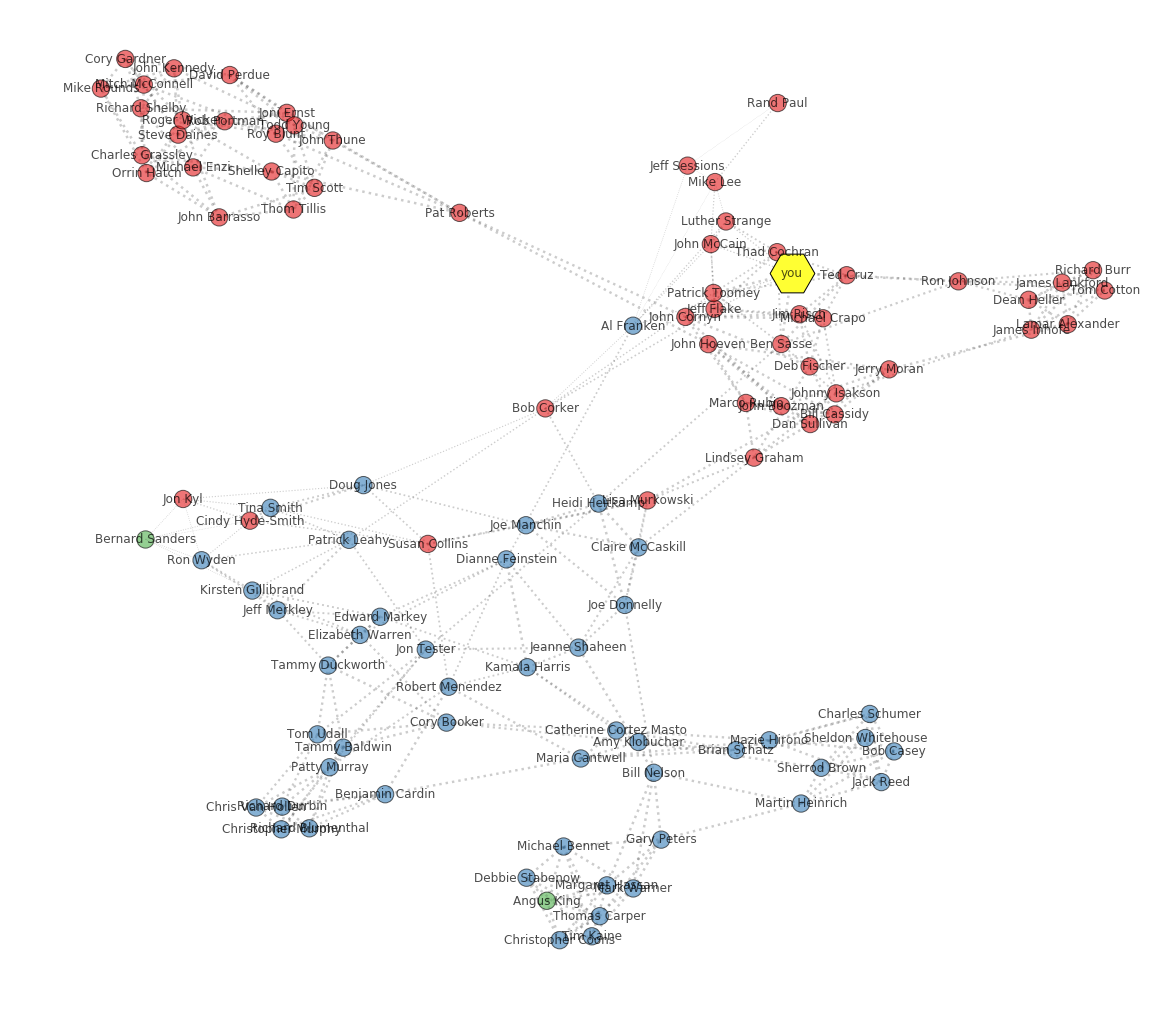

In [38]:
import itertools

plt.figure(figsize=(20,18))

pos = dict(zip(senators['name'].values[argsort_labels], coord))
pos['you'] = [0,0]

plot_signal(new_adjacency, np.append(labels, [0]), labels=np.append(senators['name'].values, ['you']),scale=[0,1], highlight_node=[105])